The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

In [1]:
library(tidyverse)
library(stringr)
library(magrittr)
library(parallel)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
library(biomaRt)
library(rtracklayer)
library(BSgenome.Hsapiens.UCSC.hg19)

Loading required package: GenomicRanges
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit

Loading required package: S4Vectors
Loading required package:

## Get coordinates of admixture array sites

In [3]:
source("../R/utils.R")

In [4]:
european_ids <- get_european_ids("../raw_data/10_24_2014_SGDP_metainformation_update.txt")

europeans <-
    load_dataset("../clean_data/ice_age.tsv", "../clean_data/sgdp.tsv", "../clean_data/archaics.tsv") %>%
    dplyr::select(c("chrom", "pos", european_ids)) %>% 
    dplyr::mutate(chrom=paste0("chr", chrom), start=pos, end=pos)

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c

In [5]:
sites <- makeGRangesFromDataFrame(europeans)
seqinfo(sites) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

In [6]:
length(sites)

[1] 484016

In [7]:
head(sites)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]     chr1 [847983, 847983]      *
  [2]     chr1 [853089, 853089]      *
  [3]     chr1 [853596, 853596]      *
  [4]     chr1 [854793, 854793]      *
  [5]     chr1 [867552, 867552]      *
  [6]     chr1 [871401, 871401]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Calculate the overlap of each window with each annotation feature

Those black magic GRanges overlap tricks are from [here](https://support.bioconductor.org/p/56880/).

In [382]:
WINDOW_SIZE <- 10

Testing sites, testing windows and testing exons

### Developing the code on a simple test example

In [383]:
# sites
(s <- GRanges(seqnames="chr1", ranges=IRanges(c(10, 16, 22, 100), width=1)))
seqinfo(s) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# windows around sites
(w <- flank(s, as.integer(WINDOW_SIZE / 2), both=TRUE))
seqinfo(w) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# regions of interest (like exons)
(r <- GRanges(seqnames="chr1", ranges=IRanges(start=c(7, 12, 16, 200), end=c(9, 13, 21, 220))))
seqinfo(r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [ 10,  10]      *
  [2]     chr1 [ 16,  16]      *
  [3]     chr1 [ 22,  22]      *
  [4]     chr1 [100, 100]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 4 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1 [ 5,  14]      *
  [2]     chr1 [11,  20]      *
  [3]     chr1 [17,  26]      *
  [4]     chr1 [95, 104]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [  7,   9]      *
  [2]     chr1 [ 12,  13]      *
  [3]     chr1 [ 16,  21]      *
  [4]     chr1 [200, 220]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [161]:
WINDOW_SIZE <- 10

Calculate the # of overlapping bases for each window:

In [384]:
# get the hit table between windows and regions they overlap with
(hits <- findOverlaps(w, r))

Hits object with 5 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]         1           1
  [2]         1           2
  [3]         2           2
  [4]         2           3
  [5]         3           3
  -------
  queryLength: 4 / subjectLength: 4

In [385]:
# get all overlapping regions (duplicates for regions
# overlapping several windows/sites)
(w_over <- pintersect(w[queryHits(hits)], r[subjectHits(hits)]))

GRanges object with 5 ranges and 1 metadata column:
      seqnames    ranges strand |       hit
         <Rle> <IRanges>  <Rle> | <logical>
  [1]     chr1  [ 7,  9]      * |      TRUE
  [2]     chr1  [12, 13]      * |      TRUE
  [3]     chr1  [12, 13]      * |      TRUE
  [4]     chr1  [16, 20]      * |      TRUE
  [5]     chr1  [17, 21]      * |      TRUE
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [386]:
# for each window count the number of overlapping bases in regions
# as an integer vector
(w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) sum(width(x))))

1 2 3 
5 7 5

In [387]:
# add the column with % overlap to the original sites object
s$overlap <- 0
s$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / WINDOW_SIZE
s

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

### The code seems to work, let's construct a function:

In [388]:
calc_window_overlaps <- function(sites, regions, window_size) {
    # construct windows around each site
    windows <- flank(sites, as.integer(window_size / 2), both=TRUE)
    seqinfo(windows) <- seqinfo(sites)

    # get the hit table between windows and regions they overlap with
    hits <- findOverlaps(windows, regions)

    # get the all overlapping regions (duplicates for regions
    # overlapping several windows/sites)
    w_over <- pintersect(windows[queryHits(hits)], regions[subjectHits(hits)])

    # for each window count the number of overlapping bases in regions
    # as an integer vector
    w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) { sum(width(x)) })

    # add the column with % overlap to the original sites object
    sites$overlap <- 0 # by default zero overlap for each site
    sites$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / window_size

    sites
}

Test of this function on the toy dataset from above:

In [389]:
calc_window_overlaps(granges(s), r, WINDOW_SIZE)

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Getting exon coordinates

Show all the available biomarts for hg19:

In [10]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 89
ENSEMBL_MART_SNP,Ensembl Variation 89
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 89


Connect to the human gene Ensembl dataset:

In [11]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [12]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

Get coordinates of exons from the gene annotation database:

In [16]:
exons_df <-
    getBM((listAttributes(genes) %>% filter(page=="structure"))$name,    # get all attributes
          filters=c("chromosome_name", "biotype"),                       # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),                           # chromosomes 1:22 and "protein_coding"
          mart=genes)

exons_gr <- 
    dplyr::select(exons_df, chromosome_name, exon_chrom_start, exon_chrom_end) %>%
    setNames(c("chrom", "start", "end")) %>%                             # rename the columns to BED names
    mutate(chrom=paste0("chr", chrom)) %>%                               # convert chromosome IDs to USCS format
    makeGRangesFromDataFrame %>%                                         # convert to GRanges object
    reduce                                                               # merge overlapping exons

In [18]:
seqinfo(exons_gr) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

How many exons did I get? What is the total length of the exonic sequence (in Mb) that we extracted?

Bioinformatic databases are a mess - are the numbers I got reasonable?

In [19]:
length(exons_gr)
sum(width(exons_gr)) / 1e6

[1] 222587

[1] 89.81306

In [320]:
WINDOW_SIZE <- 100000

exon_densities <-
    mclapply(paste0("chr", 1:22),
             function(chr) {
                 calc_window_overlaps(sites[seqnames(sites) == chr], exons, WINDOW_SIZE)
             }, mc.cores=22) %>%
    do.call(c, .)

In [321]:
exon_densities

GRanges object with 484016 ranges and 1 metadata column:
           seqnames               ranges strand |   overlap
              <Rle>            <IRanges>  <Rle> | <numeric>
       [1]     chr1     [847983, 847983]      * |   0.09822
       [2]     chr1     [853089, 853089]      * |    0.1211
       [3]     chr1     [853596, 853596]      * |    0.1211
       [4]     chr1     [854793, 854793]      * |    0.1211
       [5]     chr1     [867552, 867552]      * |   0.17652
       ...      ...                  ...    ... .       ...
  [484012]    chr22 [51142979, 51142979]      * |   0.09574
  [484013]    chr22 [51145136, 51145136]      * |   0.09574
  [484014]    chr22 [51154908, 51154908]      * |   0.09574
  [484015]    chr22 [51174091, 51174091]      * |   0.14187
  [484016]    chr22 [51177248, 51177248]      * |   0.14187
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Calculate the overlap of each window with each annotation feature

Those black magic GRanges overlap tricks are from [here](https://support.bioconductor.org/p/56880/).

### Developing the code on a simple test example

Testing sites, testing windows and testing exons

In [20]:
WINDOW_SIZE <- 10

In [21]:
# sites
(s <- GRanges(seqnames="chr1", ranges=IRanges(c(10, 16, 22, 100), width=1)))
seqinfo(s) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# windows around sites
(w <- flank(s, as.integer(WINDOW_SIZE / 2), both=TRUE))
seqinfo(w) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# regions of interest (like exons)
(r <- GRanges(seqnames="chr1", ranges=IRanges(start=c(7, 12, 16, 200), end=c(9, 13, 21, 220))))
seqinfo(r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [ 10,  10]      *
  [2]     chr1 [ 16,  16]      *
  [3]     chr1 [ 22,  22]      *
  [4]     chr1 [100, 100]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 4 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1 [ 5,  14]      *
  [2]     chr1 [11,  20]      *
  [3]     chr1 [17,  26]      *
  [4]     chr1 [95, 104]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [  7,   9]      *
  [2]     chr1 [ 12,  13]      *
  [3]     chr1 [ 16,  21]      *
  [4]     chr1 [200, 220]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

Calculate the # of overlapping bases for each window:

In [22]:
# get the hit table between windows and regions they overlap with
(hits <- findOverlaps(w, r))

Hits object with 5 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]         1           1
  [2]         1           2
  [3]         2           2
  [4]         2           3
  [5]         3           3
  -------
  queryLength: 4 / subjectLength: 4

In [23]:
# get all overlapping regions (duplicates for regions
# overlapping several windows/sites)
(w_over <- pintersect(w[queryHits(hits)], r[subjectHits(hits)]))

GRanges object with 5 ranges and 1 metadata column:
      seqnames    ranges strand |       hit
         <Rle> <IRanges>  <Rle> | <logical>
  [1]     chr1  [ 7,  9]      * |      TRUE
  [2]     chr1  [12, 13]      * |      TRUE
  [3]     chr1  [12, 13]      * |      TRUE
  [4]     chr1  [16, 20]      * |      TRUE
  [5]     chr1  [17, 21]      * |      TRUE
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [24]:
# for each window count the number of overlapping bases in regions
# as an integer vector
(w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) sum(width(x))))

1 2 3 
5 7 5

In [25]:
# add the column with % overlap to the original sites object
s$overlap <- 0
s$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / WINDOW_SIZE
s

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

### The code seems to work, let's construct a function:

In [26]:
calc_window_overlaps <- function(sites, regions, window_size) {
    # construct windows around each site
    windows <- flank(sites, as.integer(window_size / 2), both=TRUE)
    seqinfo(windows) <- seqinfo(sites)

    # get the hit table between windows and regions they overlap with
    hits <- findOverlaps(windows, regions)

    # get the all overlapping regions (duplicates for regions
    # overlapping several windows/sites)
    w_over <- pintersect(windows[queryHits(hits)], regions[subjectHits(hits)])

    # for each window count the number of overlapping bases in regions
    # as an integer vector
    w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) { sum(width(x)) })

    # add the column with % overlap to the original sites object
    sites$overlap <- 0 # by default zero overlap for each site
    sites$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / window_size

    sites
}

Test of this function on the toy dataset from above:

In [27]:
calc_window_overlaps(granges(s), r, WINDOW_SIZE)

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [28]:
WINDOW_SIZE <- 100000

exon_densities <-
    mclapply(paste0("chr", 1:22),
             function(chr) {
                 calc_window_overlaps(sites[seqnames(sites) == chr], exons_gr, WINDOW_SIZE)
             }, mc.cores=22) %>%
    do.call(c, .)

In [29]:
exon_densities

GRanges object with 484016 ranges and 1 metadata column:
           seqnames               ranges strand |   overlap
              <Rle>            <IRanges>  <Rle> | <numeric>
       [1]     chr1     [847983, 847983]      * |   0.09822
       [2]     chr1     [853089, 853089]      * |    0.1211
       [3]     chr1     [853596, 853596]      * |    0.1211
       [4]     chr1     [854793, 854793]      * |    0.1211
       [5]     chr1     [867552, 867552]      * |   0.17652
       ...      ...                  ...    ... .       ...
  [484012]    chr22 [51142979, 51142979]      * |   0.09574
  [484013]    chr22 [51145136, 51145136]      * |   0.09574
  [484014]    chr22 [51154908, 51154908]      * |   0.09574
  [484015]    chr22 [51174091, 51174091]      * |   0.14187
  [484016]    chr22 [51177248, 51177248]      * |   0.14187
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [30]:
# old exon densities
x <- read_tsv("../clean_data/annotations/exon_density__100000bp.bed",
              col_names=c("chrom", "start", "end", "overlap")) %>% mutate(chrom=paste0("chr", chrom))
e <- mutate(europeans, start=pos-1, end=pos) %>% dplyr::select(chrom, start, end)

exon_densities_bedops <- inner_join(x, e)

Parsed with column specification:
cols(
  chrom = col_integer(),
  start = col_integer(),
  end = col_integer(),
  overlap = col_double()
)
Joining, by = c("chrom", "start", "end")


How does the new exon density metric compare to the old one?

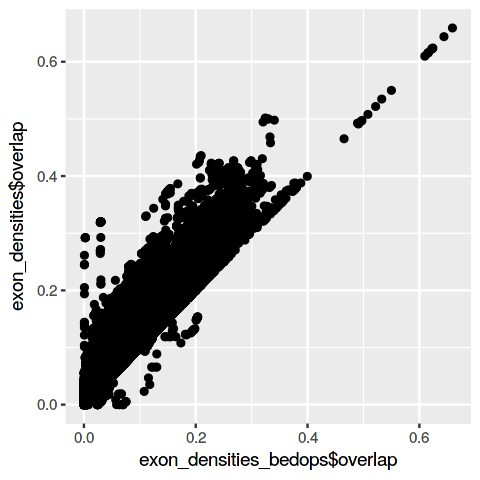

In [45]:
options(repr.plot.width=4, repr.plot.height=4)
qplot(x=exon_densities_bedops$overlap, y=exon_densities$overlap)

In [51]:
cor.test(exon_densities_bedops$overlap, exon_densities$overlap)


	Pearson's product-moment correlation

data:  exon_densities_bedops$overlap and exon_densities$overlap
t = 2763.2, df = 484010, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9695676 0.9699034
sample estimates:
     cor 
0.969736 


## Getting coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

*TODO*: Figure out how to access older snapshot of the database.

http://grch37.ensembl.org

In [48]:
listMarts()

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 89
ENSEMBL_MART_MOUSE,Mouse strains 89
ENSEMBL_MART_SNP,Ensembl Variation 89
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 89


In [49]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_regulatory_feature,Human Regulatory Features (GRCh38.p10),GRCh38.p10
hsapiens_motif_feature,Human Binding Motifs (GRCh38.p10),GRCh38.p10
hsapiens_external_feature,Human Other Regulatory Regions (GRCh38.p10),GRCh38.p10
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh38.p10),GRCh38.p10
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh38.p10),GRCh38.p10


In [50]:
reg_data <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

In [51]:
listAttributes(reg_data)
listFilters(reg_data)

name,description,page
activity,Activity,regulatory_feature
regulatory_stable_id,Regulatory stable ID,regulatory_feature
bound_seq_region_start,Bound start (bp),regulatory_feature
bound_seq_region_end,Bound end (bp),regulatory_feature
chromosome_name,Chromosome/scaffold name,regulatory_feature
chromosome_start,Start (bp),regulatory_feature
chromosome_end,End (bp),regulatory_feature
feature_type_name,Feature type,regulatory_feature
feature_type_description,Feature type description,regulatory_feature
epigenome_name,Epigenome name,regulatory_feature


name,description
chromosome_name,Chromosome Name
start,Start (bp)
end,End (bp)
chromosomal_region,"e.g 1:100:10000000, 1:100000:200000"
band_start,Band Start
band_end,Band End
marker_start,Marker Start
marker_end,Marker End
encode_region,Encode region
regulatory_stable_id,Regulatory stable ID (e.g. ENSR00000060894) [Max 500]


Download the dataframe from Biomart:

In [52]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=reg_data)

In [53]:
nrow(regulatory_features_df)

[1] 329554

Convert it into a GRanges object:

In [65]:
regulatory_features_gr <-
    dplyr::select(regulatory_features_df,
                  chrom=chromosome_name, start=chromosome_start, end=chromosome_end,
                  feature=feature_type_name) %>%
    arrange(chrom, start) %>% 
    mutate(chrom=paste0("chr", chrom)) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)
seqinfo(regulatory_features_gr) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1139 out-of-bound ranges located on sequences
  chr3, chr5, chr7, chr11, chr17, chr18, and chr20. Note that only ranges
  located on a non-circular sequence whose length is not NA can be
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”

In [66]:
length(regulatory_features_gr)

[1] 329554

In [67]:
head(regulatory_features_gr)

GRanges object with 6 ranges and 1 metadata column:
      seqnames         ranges strand |                  feature
         <Rle>      <IRanges>  <Rle> |              <character>
  [1]     chr1 [13201, 13800]      * |                 Enhancer
  [2]     chr1 [13915, 14583]      * |           Open chromatin
  [3]     chr1 [15460, 15817]      * |          TF binding site
  [4]     chr1 [19755, 20635]      * |          TF binding site
  [5]     chr1 [21062, 22000]      * | Promoter Flanking Region
  [6]     chr1 [28200, 30001]      * |                 Promoter
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome